## ARMA Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 46
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

In [1]:
import pandas as pd
data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]

In [2]:
import statsmodels.tsa.api as tsa

nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  399
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -74.099
Date:                Sun, 27 Oct 2019   AIC                            156.198
Time:                        14:32:21   BIC                            172.154
Sample:                    04-01-1953   HQIC                           162.517
                         - 06-01-1986                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0553      0.022      2.478      0.013       0.012       0.099
ar.L1          0.8934      0.017     52.946      0.000       0.860       0.926
ma.L1          0.4578      0.020     22.512      0.000       0.418       0.498
sigma2         0.0843      0.003     26.415      0.000       0.078       0.091
===================================================================================
Ljung-Box (Q):                       74.57   Jarque-Bera (JB):               916.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

fcast = forecast_res.predict()

errors = term - fcast
oos_errors = errors.iloc[half:]

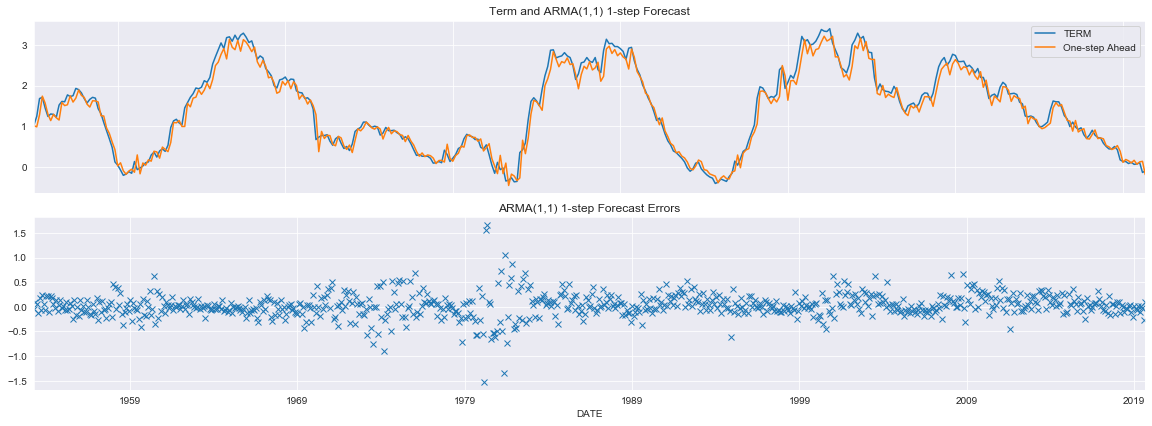

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,6))

both = pd.concat([term, fcast],1)
both.columns = ['TERM', "One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors = both.TERM - both["One-step Ahead"]
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

In [5]:
import statsmodels.api as sm

oos_fcast = sm.add_constant(fcast.iloc[half:])
oos_fcast.columns = ["Const", "Forecast"]
res = sm.OLS(oos_errors, oos_fcast).fit()

res.summary()

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     45.63
Date:                Sun, 27 Oct 2019   Prob (F-statistic):           5.11e-11
Time:                        14:32:23   Log-Likelihood:                 145.23
No. Observations:                 399   AIC:                            -286.5
Df Residuals:                     397   BIC:                            -278.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0163      0.015     -1.112      0.267      -0.045       0.013
Forecast       0.0596      0.009      6.755      0.000       0.042       0.077
==============================================================================
Omnibus:                       26.175   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.823
Skew:                           0.357   Prob(JB):                     1.25e-12
Kurtosis:                       4.670   Cond. No.                         3.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[52.45293022]]), p=6.1149886268278606e-21, df_denom=397, df_num=2>

In [7]:
rw_forecast = term.shift(1)
both = pd.concat([term, rw_forecast],1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.003
Date:                Sun, 27 Oct 2019   Prob (F-statistic):              0.158
Time:                        14:32:23   Log-Likelihood:                 126.34
No. Observations:                 399   AIC:                            -248.7
Df Residuals:                     397   BIC:                            -240.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0146      0.015      0.958      0.338      -0.015       0.044
One-step RW Forecast    -0.0122      0.009     -1.415      0.158      -0.029       0.005
==============================================================================
Omnibus:                       39.348   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.678
Skew:                           0.487   Prob(JB):                     6.16e-22
Kurtosis:                       5.220   Cond. No.                         3.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.05666189]]), p=0.3485898018436959, df_denom=397, df_num=2>

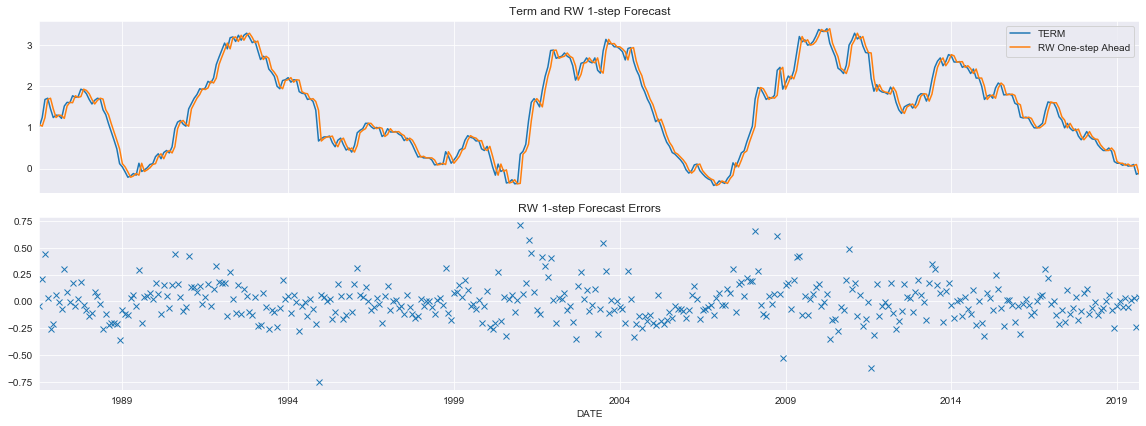

In [9]:
plt.rc("figure", figsize=(16,6))

both.columns = ['TERM', "RW One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and RW 1-step Forecast")

errors = rw_oos_error
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("RW 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Exercise 47

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


In [10]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

In [11]:
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t+2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [12]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors


1986-09-01    0.767432
1986-10-01    0.820218
1986-11-01    0.323333
1986-12-01   -0.252708
1987-01-01   -0.057501
                ...   
2019-05-01   -0.162974
2019-06-01   -0.111012
2019-07-01   -0.132571
2019-08-01   -0.295052
2019-09-01   -0.301320
Length: 397, dtype: float64

In [13]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

In [14]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=['MSE', 'MAE'])

,ARMA,RW
MSE,0.220203,0.133860
MAE,0.361171,0.281159


In [15]:
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1/3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Oct 2019   Prob (F-statistic):                nan
Time:                        14:32:26   Log-Likelihood:                -30.963
No. Observations:                 397   AIC:                             63.93
Df Residuals:                     396   BIC:                             67.91
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0863      0.027      3.218      0.001       0.034       0.139
==============================================================================
Omnibus:                       83.258   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.481
Skew:                           1.063   Prob(JB):                     7.16e-42
Kurtosis:                       5.633   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [16]:
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Oct 2019   Prob (F-statistic):                nan
Time:                        14:32:26   Log-Likelihood:                -56.167
No. Observations:                 397   AIC:                             114.3
Df Residuals:                     396   BIC:                             118.3
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0800      0.028      2.880      0.004       0.026       0.134
==============================================================================
Omnibus:                        0.535   Durbin-Watson:                   0.532
Prob(Omnibus):                  0.765   Jarque-Bera (JB):                0.651
Skew:                           0.065   Prob(JB):                        0.722
Kurtosis:                       2.850   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""